# Sweeping a parameter space (in development)

Often the researcher will want to run many photochemical models, for different parameter sets. For example, they might want to determine the surface flux of CH4, as they vary a fixed surface CH4 mixing ratio.

This can be challenging because of convergence issues. 

Any photochemical integrations begins with an initial atmosphere (called `atmosphere.txt` in `PhotochemPy`). The integration attempts to evolve this atmosphere forward in time for many billions of years. Once ~3 billion years is reached, we assume we have found a state of photochemical equililibrium.

The initial conditions matter a lot for this approach to work, . If one starts with an initial atmosphere that is "very far" from the equilibrium atmosphere, then the integration might fail to converge to the equilibrium state. One reason for convergence failures is the non-linear nature of the photochemical model equations: Its possible that there is no "path" to the equilibrium atmosphere with choosen intial conditions. Another reason for convergence failures is that the PhotochemPy time-stepping algorithm for finding equilibrium, just isn't the best.

There is a third reason for convergence failures: there is no equilibrium state to the photochemical ordinary differential equations. A parameter set might lead to an atmosphere that goes though some periodic cycle or oscillation (e.g. [limit cycles](https://en.wikipedia.org/wiki/Limit_cycle)). Such convergence failures are "physically" meaningful.

**So when running the photochemical model for a variety of input parameters, the goal is to only have convergence failures when they are "real" or "physical".** In this notebook, I use and explain an algorithm, called `AtmosSweeper` (I know, dumb name, taking ideas for better ones), which accomplishes this pretty well.

## The `AtmosSweeper` algorithm

The `AtmosSweeper` algorithm is a way to "navigate" or "travel" through a parameter space as quickly as possible, and with the smallest number of *undesirable* convergence failures. I'll explain it with an example.

The below .gif is an application of the `AtmosSweeper` algorithm to a parameter set of varying fixed CH4 and CO2 mixing ratios in the `Archean+haze` template. All these atmosphere are possible Archean-Earth atmospheres (N2-CO2 dominated with small O2).
- **Iteration 0:** The algorithm starts with some converged atmosphere on the specified grid of CH4 and CO2 mixing ratios. 
- **Iteration 1:** The algorithm attempts to run all parameter sets "imediately neighboring" the first converged atmosphere. For each run, it uses the first converged atmosphere as initial conditions. Integrations that converged or failed to converge are identified.
- **Iteration 2:** The algorithm identifies all "unexplored" parameter sets (black dots) immediately next to converged parameter sets (green dots), and attempts them. For each run, initial conditions of the closest converged atmosphere are used.
- **Iteration 3 onward:** The algorithm continues until the whole space is explored.

<img src="AtmosSweepExample.gif" alt="drawing" width="700"/>

<br/>

**The philosophy is really simple:** Only try parameter combinations that are *close* to a converged atmosphere. This means that convergence failures are more likely physical, especially if the grid of parameters is *tight*. The initial atmosphere used is so close that PhotochemPy *should* converge to a steady state, if one exists.

Few other things to mention
- **'AtmosSweep' does all of this in parallel.** E.g. At Iteration 1, there are 4 unexplored parameter sets neighboring a converged atmosphere, so all 4 are run in parallel (If you computer has <4 threads, then it will run the maximun number of threads in parallel). So, for big parameter spaces, there is a MASSIVE benefit to using a computer with many cores.
- **Any "dimension" of parameters can be considered.** In the above example, we considered varying only CH4 and CO2. This is a 2-dimensional parameter space. But we could have considered a 3-D parameter space (e.g. CH4, CO2, and CO) or any higher dimensional parameter space.
- **`AtmosSweep` can only be used for parameter spaces of fixed surface mixing ratios.** But this will change! I need to generalize it to any input parameter.


After sweeping the parameter space shown in the above .gif, we can plot cool stuff. For example, the figure below shows how the CH4 surface flux varies with set CH4 and CO2 surface mixing ratios. The white space in the plot is where the model didn't converge.

<img src="results.jpg" alt="drawing" width="450"/>

# How to use `AtmosSweep`

You must have PhotochemPy installed. Also, you must set the following environment variable: `export OMP_NUM_THREADS=1` in a terminal BEFORE opening this notebook. Do this in the same terminal that you open this notebook with. This turns off multithreading in PhotochemPy, which will speed up whole-parallel runs.

In [1]:
import AtmosSweeper # import it (its in the folder)
import numpy as np
from matplotlib import pyplot as plt

First, select some input files. Here, I use the Archean template.

In [2]:
files = ['../../input/templates/Archean+haze/species.dat', \
         '../../input/templates/Archean+haze/reactions.rx', \
         '../../input/templates/Archean+haze/planet.dat', \
         '../../input/templates/Archean+haze/input_photchem.dat', \
         '../../input/templates/Archean+haze/atmosphere.txt', \
         '../../input/templates/Archean+haze/Sun_2.7Ga.txt']

Now select arrays of parameters. These arrays will be used to build a grid of parameter in `AtmosSweep`. They must be in log10 space!!!

In [5]:
# Methane
low = -4
high = -2.5
step = .5
fCH4 = np.arange(low,high+1e-10,step) # LOG 10 space!!!!

# CO2
low = -2.5
high = -1
step = .5
fCO2 = np.arange(low,high+1e-10,step) # LOG 10 space!!!!

# make a dictionary of the parameters
params = {'CH4':fCH4,
          'CO2':fCO2}

So, within AtmosSweep, the following grid of parameters will be generated:

Number of points in grid = 16


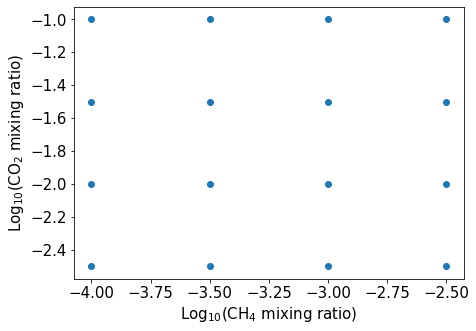

In [6]:
param_space = np.meshgrid(*(v for _, v in params.items()),indexing='ij')

print('Number of points in grid =',len(param_space[0].flatten()))

plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=[7,5])
ax.scatter(param_space[0].flatten(),param_space[1].flatten())
ax.set_xlabel('Log$_{10}$(CH$_4$ mixing ratio)')
ax.set_ylabel('Log$_{10}$(CO$_2$ mixing ratio)')

plt.show()

Now we are set to sweep through the space. This command will take a few minutes. So sit back and relax.

`nsteps_list`, is a list containing all the numbers of timesteps used by the integrator that should be attempted to solve for the grid. So, if you did `nsteps_list = [1000,2000]`, then the algorithm would first try to solve for the grid with `nsteps = 1000`. Then, if any calculations failed to converge, after sweeping the whole grid, the algorithm would re-try parameter combinations that failed to converge with `nsteps = 2000`. More timesteps could possible help the unconverged points, converge. Generally speaking start with `nsteps = 1000`, then maybe go up from there. 

In [7]:
out = AtmosSweeper.sweep(files, \
                         params, \
                         max_processes = 6, \ # have 6 cores
                         verbose=True, \
                         nsteps_list=[1000], \
                         nsteps_init = 1000)

Trying to move to closest point on the grid...
Successful. Now starting the parameter sweep.

Solving for grid with nsteps = 1000
| ITERATION 0                          |
| Converged =              1           |
| Failed to Converged =    0           |
| Unattempted =            15          |
| Possible Moves =         3           |
| Time to try all moves =  124 s       |
|                                      |
| ITERATION 1                          |
| Converged =              3           |
| Failed to Converged =    1           |
| Unattempted =            12          |
| Possible Moves =         3           |
| Time to try all moves =  66 s        |
|                                      |
| ITERATION 2                          |
| Converged =              6           |
| Failed to Converged =    1           |
| Unattempted =            9           |
| Possible Moves =         4           |
| Time to try all moves =  125 s       |
|                                      |
| ITERATI

First, the algorithmm trys to calculate the "closest" parameter set on the grid to the input `atmosphere.txt`. Then it starts a big iterative loop.

You can see all the parallel processes its running by opening a separate terminal, and running the command `htop`.

The output, is a list with 3 elements
`out[0]` = An array, the shape of the parameter space, with a dictionary containing the atmospheric composition

`out[1]` = An array, the shape of the parameter space, with a dictionary containing the surface fluxes of each molecule.

`out[2]` = A list of numpy arrays, showing the progress of each iteration. Zeros are unexplored, Ones are converged, and Twos are failed convergence.

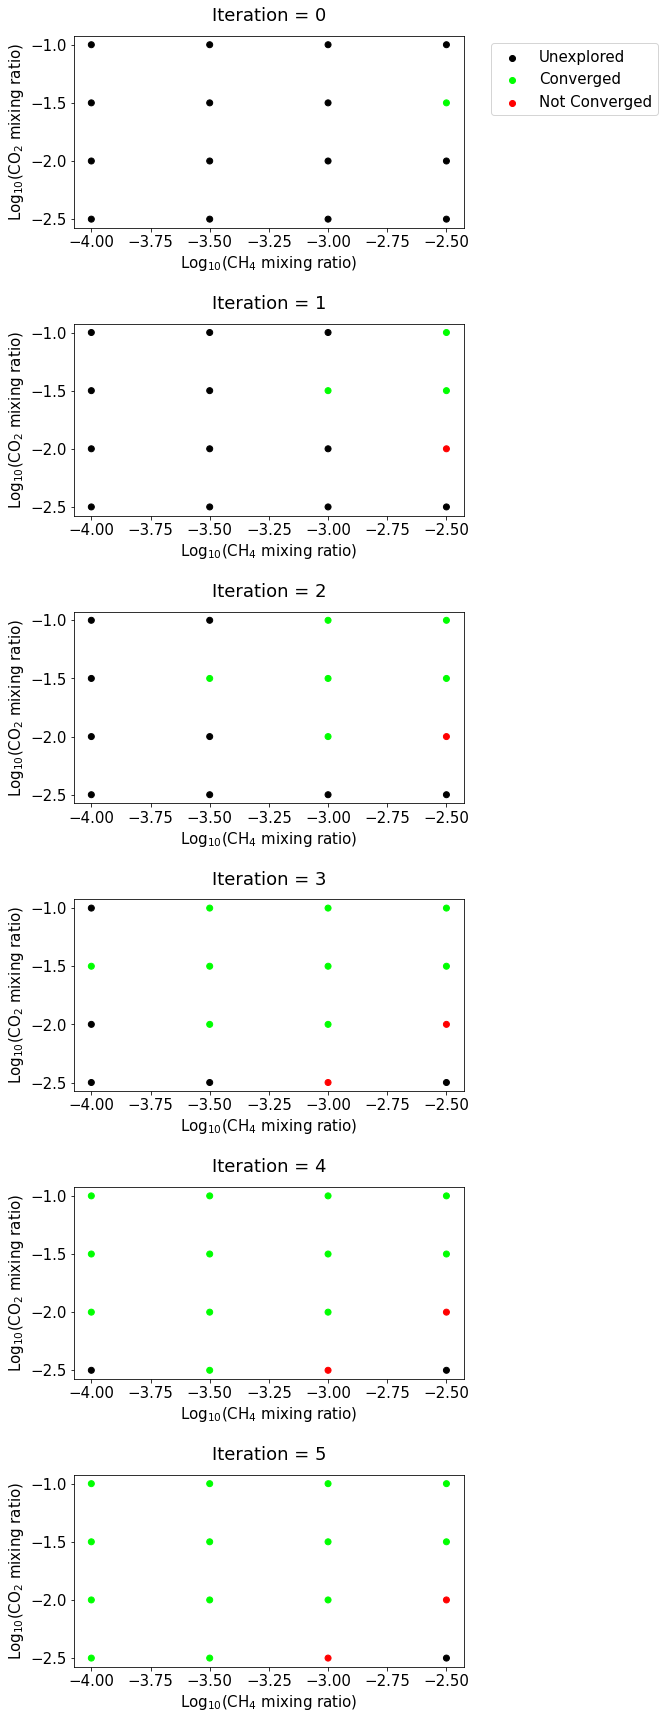

In [24]:
# lets first plot the progress through time
plt.rcParams.update({'font.size': 15})

track_progress = np.array(out[2])

def pltcolor(lst):
    cols=[]
    for l in lst:
        if l==2:
            cols.append('red')
        elif l==0:
            cols.append('k')
        else:
            cols.append('lime')
    return cols

fig,axs = plt.subplots(len(track_progress),1,figsize=[7,5*len(track_progress)])

for k,array in enumerate(track_progress):
    ax = axs[k]
    cols = pltcolor(track_progress[k].flatten())    
    ax.scatter(param_space[0].flatten(),param_space[1].flatten(),c=cols)    
    ax.set_xlabel('Log$_{10}$(CH$_4$ mixing ratio)')
    ax.set_ylabel('Log$_{10}$(CO$_2$ mixing ratio)')
    ax.set_xlim(ax.get_xlim()[0],ax.get_xlim()[1])
    ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1])
    ax.scatter(-100,100,c='k',label='Unexplored')
    ax.scatter(-100,100,c='lime',label='Converged')
    ax.scatter(-100,100,c='r',label='Not Converged')
    if k==0:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_title('Iteration = '+str(k),pad=15)

plt.subplots_adjust(hspace=.5)
plt.show()

Now we can make a plot of CH4 surface flux vs. CH4 and CO2 mixing ratio

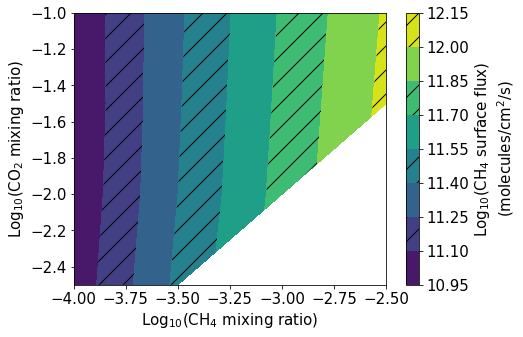

In [28]:
plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=[7,5])

fluxes = out[1] # fluxes
PhiCH4 = np.zeros(fluxes.shape)*np.nan
for i in range(fluxes.shape[0]):
    for j in range(fluxes.shape[1]):
        try:
            PhiCH4[i,j] = fluxes[i,j]['CH4']
        except:
            pass

cs = ax.contourf(param_space[0],param_space[1],np.log10(PhiCH4),hatches=[None,'/',])
cbar = fig.colorbar(cs)
ax.set_xlabel('Log$_{10}$(CH$_4$ mixing ratio)')
ax.set_ylabel('Log$_{10}$(CO$_2$ mixing ratio)')
cbar.set_label("Log$_{10}$(CH$_4$ surface flux)\n(molecules/cm$^2$/s)")

plt.show()

Or we could plot any other variable. lets plot H2 mixing ratio

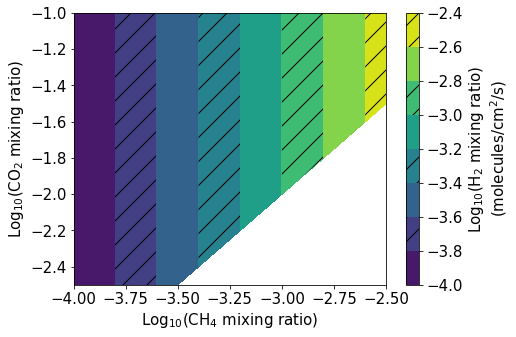

In [30]:
plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=[7,5])

mix = out[0] # atmosheres
H2 = np.zeros(mix.shape)*np.nan
for i in range(mix.shape[0]):
    for j in range(mix.shape[1]):
        try:
            H2[i,j] = mix[i,j]['CH4'][0] # ground level H2
        except:
            pass

cs = ax.contourf(param_space[0],param_space[1],np.log10(H2),hatches=[None,'/',])
cbar = fig.colorbar(cs)
ax.set_xlabel('Log$_{10}$(CH$_4$ mixing ratio)')
ax.set_ylabel('Log$_{10}$(CO$_2$ mixing ratio)')
cbar.set_label("Log$_{10}$(H$_2$ mixing ratio)\n(molecules/cm$^2$/s)")

plt.show()

Or we could look at the maximum O2 mixing ratio, and corresponding altitude. As CO2 decreases, photochemically produced O2 decreases. As CH4 increases, it blocks photons from hitting O2, so O2 increases.

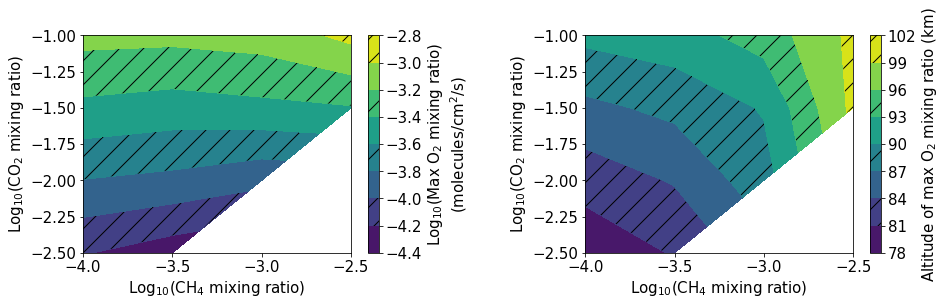

In [42]:
plt.rcParams.update({'font.size': 15})
fig,[ax,ax1] = plt.subplots(1,2,figsize=[15,4])

mix = out[0] # atmosheres
O2 = np.zeros(mix.shape)*np.nan
alt = np.zeros(mix.shape)*np.nan

for i in range(mix.shape[0]):
    for j in range(mix.shape[1]):
        try:
            ind = np.argmax(mix[i,j]['O2'])
            O2[i,j] = mix[i,j]['O2'][ind]
            alt[i,j] = mix[i,j]['alt'][ind]    
        except:
            pass

cs = ax.contourf(param_space[0],param_space[1],np.log10(O2),hatches=[None,'/',])
cbar = fig.colorbar(cs,ax=ax)
ax.set_xlabel('Log$_{10}$(CH$_4$ mixing ratio)')
ax.set_ylabel('Log$_{10}$(CO$_2$ mixing ratio)')
cbar.set_label("Log$_{10}$(Max O$_2$ mixing ratio)\n(molecules/cm$^2$/s)")

cs = ax1.contourf(param_space[0],param_space[1],alt,hatches=[None,'/',])
cbar1 = fig.colorbar(cs,ax=ax1)
ax1.set_xlabel('Log$_{10}$(CH$_4$ mixing ratio)')
ax1.set_ylabel('Log$_{10}$(CO$_2$ mixing ratio)')
cbar1.set_label("Altitude of max O$_2$ mixing ratio (km)")

plt.subplots_adjust(wspace=.5)
plt.show()

Or we could plot every CH4 profile. You can see that for low CO2, CH4 photolyzes deep into the atmosphere.

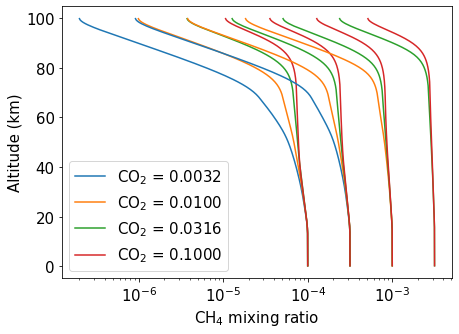

In [58]:
plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=[7,5])

def pltcolor(l):
    if l==0:
        cols = 'C0'
    elif l==1:
        cols = 'C1'
    elif j==2:
        cols = 'C2'
    else:
        cols = 'C3'
    return cols

mix = out[0] # atmosheres
temp = 0
for i in range(mix.shape[0]):
    for j in range(mix.shape[1]):
        try:
            if i == 0:
                ax.plot(mix[i,j]['CH4'],mix[i,j]['alt'],pltcolor(j),label='CO$_2$ = '+'%.4f'%(10**params['CO2'][j])) 
            else:
                ax.plot(mix[i,j]['CH4'],mix[i,j]['alt'],pltcolor(j)) 
        except:
            pass

ax.set_xscale('log')
ax.set_xlabel('CH$_4$ mixing ratio')
ax.set_ylabel('Altitude (km)')
ax.legend()

plt.show()

There is a ton of output here. The sky is the limit.